<a href="https://colab.research.google.com/github/chrishendra93/MI_Workshop/blob/main/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [4]:
np.random.seed(0)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_dir = "/content/drive/MyDrive/Journal Club MIL/mnist_clr"

mnist_columns = ["label"] + ["features_{}".format(i) for i in range(28 ** 2)]
mnist_train = pd.read_csv("./sample_data/mnist_train_small.csv", names=mnist_columns)
mnist_test = pd.read_csv("./sample_data/mnist_test.csv", names=mnist_columns)
mnist_arr_train = mnist_train[["features_{}".format(i) for i in range(28 ** 2)]].values
mnist_arr_test = mnist_test[["features_{}".format(i) for i in range(28 ** 2)]].values

X_train = np.load(os.path.join(root_dir, "train_features.npy"))
X_test = np.load(os.path.join(root_dir, "test_features.npy"))
y_train = np.load(os.path.join(root_dir, "train_labels.npy"))
y_test = np.load(os.path.join(root_dir, "test_labels.npy"))

print(np.all(y_train == mnist_train["label"].values))
print(np.all(y_test == mnist_test["label"].values))



True
True


In [39]:
import copy

def create_bags(mnist_df):
    """
    bags: {key1: [ind1, ind2, ind3],
           key2: [ind1, ind2, ind3, ind4, ind5],
           ... }
    bag_lbls:
        {key1: 0,
         key2: 1,
         ... }
    """
    bags = []
    i = 0
    all_indices, all_labels = np.arange(len(mnist_df)), mnist_df["label"].values
    np.random.shuffle(all_indices)
    bag_labels = []
    all_labels = all_labels[all_indices]
    while i < len(mnist_df):
      bag_size = np.random.randint(3, 7)
      indices = all_indices[i: i + bag_size]
      labels = all_labels[i: i + bag_size]
      bag_labels.append(get_bag_label(labels))
      bags.append(indices)
      i += bag_size
    return np.array(bags), np.array(bag_labels)

def get_bag_label(instance_labels):
  return (np.any(instance_labels == 9) & np.any(instance_labels == 5))* 1


In [40]:
train_bags, train_labels = create_bags(mnist_train)
test_bags, test_labels = create_bags(mnist_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(array([1956.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         264.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

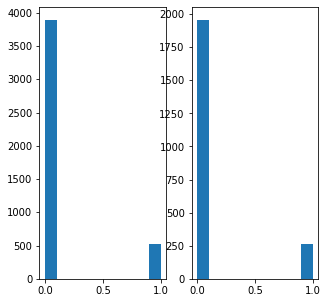

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist(train_labels)
axes[1].hist(test_labels)


(array([569.,   0.,   0., 518.,   0.,   0., 577.,   0.,   0., 556.]),
 array([3. , 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 10 Patch objects>)

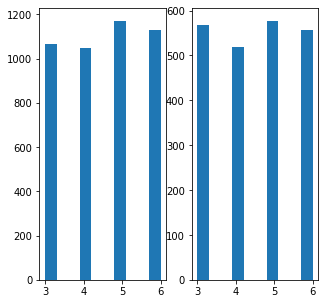

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist([len(bag) for bag in train_bags])
axes[1].hist([len(bag) for bag in test_bags])


In [44]:
print(len(train_bags))
print(len(test_bags))

4410
2220


(array([1956.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         264.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

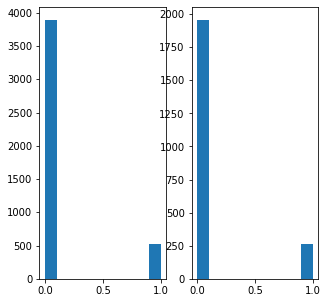

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist(train_labels)
axes[1].hist(test_labels)


(array([569.,   0.,   0., 518.,   0.,   0., 577.,   0.,   0., 556.]),
 array([3. , 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 10 Patch objects>)

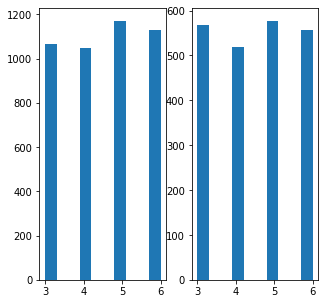

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].hist([len(bag) for bag in train_bags])
axes[1].hist([len(bag) for bag in test_bags])


In [49]:
print(len(train_bags))
print(len(test_bags))

4410
2220


In [50]:
import torch.nn.functional as F
import torch
from torch import nn
from torch.nn import BCELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

In [51]:
class LogisticRegressionMI(nn.Module):

  def __init__(self, n_dim, mode='max'):
    super(LogisticRegressionMI, self).__init__()
    if mode not in ('max', 'mean'):
      raise ValueError("Invalid mode {}, must be one of max or mean".format(mode))
    self.mode = mode
    self.encoder = nn.Linear(n_dim, 1)
    
  def forward(self, x, indices):
    x = self.encoder(x)
    x = torch.sigmoid(x)
    if self.mode == 'max':
      x = torch.stack([torch.max(x[idx]) for idx in indices])
    else:
      x = torch.stack([torch.mean(x[idx]) for idx in indices])
    return x
  
  def get_max_indices(self, x, indices):
    x = self.encoder(x)
    x = torch.sigmoid(x)
    pred, max_indices = [], []
    for idx in indices:
      max_idx = torch.argmax(x[idx])
      max_indices.append(idx[max_idx])
      pred.append(x[idx][max_idx])
    return torch.cat(pred), np.array(max_indices)


class nnMI(nn.Module):

  def __init__(self, encoder, mode='max'):
    super(nnMI, self).__init__()
    if mode not in ('max', 'mean'):
      raise ValueError("Invalid mode {}, must be one of max or mean".format(mode))
    self.mode = mode
    self.encoder = encoder
    
  def forward(self, x, indices):
    x = self.encoder(x)
    if self.mode == 'max':
      x = torch.stack([torch.max(x[idx]) for idx in indices])
    else:
      x = torch.stack([torch.mean(x[idx]) for idx in indices])
    return x

  

class nnMIMax(nn.Module):

  def __init__(self, encoder, decoder, mode='max'):
    super(nnMIMax, self).__init__()
    if mode not in ('max', 'mean'):
      raise ValueError("Invalid mode {}, must be one of max or mean".format(mode))
    self.mode = mode
    self.encoder = encoder
    self.decoder = decoder
    
  def forward(self, x, indices):
    x = self.encoder(x)
    if self.mode == 'max':
      x = torch.stack([torch.max(x[idx], axis=0).values for idx in indices])
    else:
      x = torch.stack([torch.mean(x[idx], axis=0).values for idx in indices])
    x = self.decoder(x)
    return x



In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
from scipy.stats import mode

def get_roc_auc(y_true, y_pred):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def get_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

In [53]:
logit_mi = LogisticRegressionMI(64, mode='mean')
criterion = BCELoss()
optimizer = LBFGS(logit_mi.parameters(), lr=0.001, max_iter=1000)
logit_mi.train()


def closure():
    optimizer.zero_grad()
    output = logit_mi(torch.Tensor(X_train), train_bags)
    loss = criterion(output, torch.Tensor(train_labels))
    loss.backward()
    return loss

optimizer.step(closure) 

logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test = logit_mi(torch.Tensor(X_test), [bag[0] for bag in test_bags]).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.6464104232509141
PR AUC: 0.21172735612810945
Accuracy Score: 0.872072072072072
Balanced Accuracy Score: 0.5260155233314743


In [54]:
logit_mi = LogisticRegressionMI(64, mode='max')

classes, counts = np.unique(train_labels, return_counts=True)
class_weights = 1./torch.tensor(counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
weights = torch.zeros(len(train_labels))
weights[np.argwhere(train_labels == 0)] = class_weights[0] / counts[0]
weights[np.argwhere(train_labels == 1)] = class_weights[1] / counts[1]

criterion = BCELoss(weight=weights)

logit_mi.train()


optimizer = Adam(logit_mi.parameters(), lr=4e-3)
n_epochs = 100

for i in range(n_epochs):
  optimizer.zero_grad()
  output = logit_mi(torch.Tensor(X_train), train_bags)
  loss = criterion(output, torch.Tensor(train_labels))
  loss.backward()
  optimizer.step() 

logit_mi.eval()
with torch.no_grad():
  y_pred_logit_mi_test = logit_mi(torch.Tensor(X_test), [bag[0] for bag in test_bags]).detach().numpy()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_logit_mi_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_logit_mi_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_logit_mi_test >= 0.5)))

ROC AUC: 0.6071683088554254
PR AUC: 0.17631849320790624
Accuracy Score: 0.21216216216216216
Balanced Accuracy Score: 0.5168711656441718


In [66]:
device = 'cuda'

nn_mi = nnMI(nn.Sequential(*[nn.Linear(64, 128), nn.ReLU(),
                             nn.Linear(128, 64), nn.ReLU(),
                             nn.Linear(64, 1)]), mode='max').to(device)

classes, counts = np.unique(train_labels, return_counts=True)
class_weights = 1 /torch.tensor(counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()

weights = torch.zeros(len(train_labels))
weights[np.argwhere(train_labels == 0)] = class_weights[0]
weights[np.argwhere(train_labels == 1)] = class_weights[1]

criterion = nn.BCEWithLogitsLoss(weight=weights).to(device)

optimizer = Adam(nn_mi.parameters(), lr=4e-5)
n_epochs = 100

for i in range(n_epochs):
  nn_mi.train()
  optimizer.zero_grad()
  output = nn_mi(torch.Tensor(X_train).to(device), train_bags)
  loss = criterion(output, torch.Tensor(train_labels).to(device))
  loss.backward()
  optimizer.step() 

nn_mi.eval()
with torch.no_grad():
  y_pred_nn_test = torch.sigmoid(nn_mi(torch.Tensor(X_test).to(device), test_bags)).detach().cpu().numpy().flatten()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_nn_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_nn_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_nn_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_nn_test >= 0.5)))


ROC AUC: 0.7967791411042946
PR AUC: 0.2781078053837687
Accuracy Score: 0.5554054054054054
Balanced Accuracy Score: 0.7034648633575014


In [68]:
device = 'cuda'

nn_mi = nnMIMax(nn.Sequential(*[nn.Linear(64, 128), nn.ReLU(),
                               nn.Linear(128, 64), nn.ReLU()]),
                nn.Sequential(*[nn.Linear(64, 128), nn.ReLU(), 
                                nn.Linear(128, 64), nn.ReLU(),
                                nn.Linear(64, 1)]), mode='max').to(device)

classes, counts = np.unique(train_labels, return_counts=True)
class_weights = 1./torch.tensor(counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()

weights = torch.zeros(len(train_labels))
weights[np.argwhere(train_labels == 0)] = class_weights[0]
weights[np.argwhere(train_labels == 1)] = class_weights[1]

criterion = nn.BCEWithLogitsLoss(weight=weights).to(device)

optimizer = Adam(nn_mi.parameters(), lr=4e-3)
n_epochs = 100

for i in range(n_epochs):
  nn_mi.train()
  optimizer.zero_grad()
  output = nn_mi(torch.Tensor(X_train).to(device), train_bags)
  loss = criterion(output.flatten(), torch.Tensor(train_labels).to(device))
  loss.backward()
  optimizer.step() 

nn_mi.eval()
with torch.no_grad():
  y_pred_nn_test = torch.sigmoid(nn_mi(torch.Tensor(X_test).to(device), test_bags)).detach().cpu().numpy().flatten()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_nn_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_nn_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_nn_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_nn_test >= 0.5)))


ROC AUC: 0.9331350312945405
PR AUC: 0.7001917118692033
Accuracy Score: 0.913963963963964
Balanced Accuracy Score: 0.8561535601412902


In [60]:
nn_mi.eval()
with torch.no_grad():
  y_pred_nn_test = torch.sigmoid(nn_mi(torch.Tensor(X_test).to(device), test_bags)).detach().cpu().numpy().flatten()
  print("ROC AUC: {}".format(get_roc_auc(test_labels, y_pred_nn_test)))
  print("PR AUC: {}".format(get_pr_auc(test_labels, y_pred_nn_test)))
  print("Accuracy Score: {}".format(accuracy_score(test_labels, y_pred_nn_test >= 0.5)))
  print("Balanced Accuracy Score: {}".format(balanced_accuracy_score(test_labels, y_pred_nn_test >= 0.5)))

ROC AUC: 0.9399090599243972
PR AUC: 0.7245673155968184
Accuracy Score: 0.9031531531531531
Balanced Accuracy Score: 0.8680400632087749


In [69]:
np.save("train_labels.npy", train_labels)
np.save("train_bags.npy", train_bags)

np.save("test_labels.npy", test_labels)
np.save("test_bags.npy", test_bags)


In [70]:
from google.colab import files

files.download('train_bags.npy') 
files.download('train_labels.npy') 

files.download('test_bags.npy') 
files.download('test_labels.npy') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>